# Introduction

The dataset in this notebook was generated to create a model capable of automatically detecting instances of faults related to outdoor temperature sensor biases. To construct this dataset, a comprehensive office building model was employed. This model was crafted using a co-simulation framework that amalgamates a building envelope model (constructed with EnergyPlus) and a building HVAC system model (constructed with Dymola).

To simulate faults, deviations were manually introduced into the simulation model by overriding the control signals. Each simulated fault persisted for a single day, encompassing the entire 24-hour period.

The readings from the outdoor temperature sensor are of critical importance due to their potential impact on the automation of HVAC equipment. Errors in these readings can lead to suboptimal system performance, potentially resulting in elevated energy consumption or the inability to achieve desired air quality parameters.

Authors of the dataset provided following data:

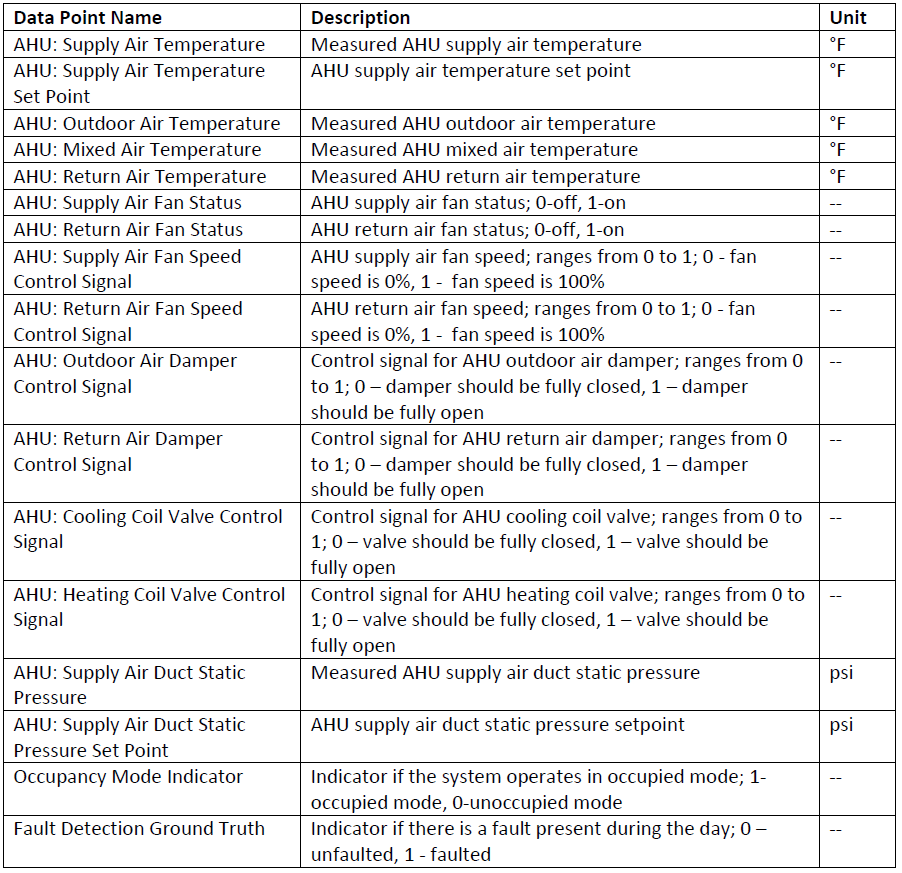

# Import of the relevant libraries and notebook preparation

In [1]:
import sys
import os

In [2]:
src_path = os.path.join(os.getcwd(), "..", "src")
sys.path.append(src_path)

In [3]:
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor,AdaBoostRegressor,BaggingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression

In [4]:
# preparing list of regression algorithms for comparison and to choose the best one
regressors = [['KNeighborsRegressor', KNeighborsRegressor()],
              ['MLPRegressor',MLPRegressor()],
              ['AdaBoostRegressor',AdaBoostRegressor()],
              ['GradientBoostingRegressor',GradientBoostingRegressor()],
              ['CatBoostRegressor', CatBoostRegressor()],
              ['XGBRegressor', XGBRegressor()],
              ['BaggingRegressor', BaggingRegressor()],
              ['RandomForestRegressor', RandomForestRegressor()],
              ['DecisionTreeRegressor', DecisionTreeRegressor()],
              ['LinearRegression', LinearRegression()]]

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from helper_functions import convert_date, train_evaluate_classification_models, train_evaluate_regression_models
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [6]:
warnings.filterwarnings("ignore")

In [7]:
csv_file_path = os.path.join("..", "data", "MZVAV-1.csv")

In [8]:
data = pd.read_csv(csv_file_path)

# Data exploration and feature engineering

In [9]:
data.sample(5)

,Datetime,AHU: Supply Air Temperature,AHU: Supply Air Temperature Set Point,AHU: Outdoor Air Temperature,AHU: Mixed Air Temperature,AHU: Return Air Temperature,AHU: Supply Air Fan Status,AHU: Return Air Fan Status,AHU: Supply Air Fan Speed Control Signal,AHU: Return Air Fan Speed Control Signal,AHU: Outdoor Air Damper Control Signal,AHU: Return Air Damper Control Signal,AHU: Cooling Coil Valve Control Signal,AHU: Heating Coil Valve Control Signal,AHU: Supply Air Duct Static Pressure Set Point,AHU: Supply Air Duct Static Pressure,Occupancy Mode Indicator,Fault Detection Ground Truth
205791,11/1/2017 21:51,51.91,55.04,61.16,69.80,75.46,0,0,0.00,0.00,0.00,0.0,0.00,0,0.04,0.00,0,0
91744,5/18/2017 17:04,54.85,55.04,63.57,72.17,74.66,1,1,0.66,0.66,0.14,0.0,0.06,0,0.04,0.04,1,1
94605,5/20/2017 16:45,52.59,55.04,54.13,55.00,70.64,1,1,0.64,0.64,0.86,0.0,0.03,0,0.04,0.04,1,1
120511,6/10/2017 16:31,52.19,55.04,47.39,55.01,70.67,1,1,0.64,0.64,0.87,0.0,0.04,0,0.04,0.04,1,1
18107,2/11/2017 13:47,53.99,55.04,53.57,55.05,71.03,1,1,0.65,0.65,0.88,0.0,0.01,0,0.04,0.04,1,1


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272160 entries, 0 to 272159
Data columns (total 18 columns):
 #   Column                                          Non-Null Count   Dtype  
---  ------                                          --------------   -----  
 0   Datetime                                        272160 non-null  object 
 1   AHU: Supply Air Temperature                     272160 non-null  float64
 2   AHU: Supply Air Temperature Set Point           272160 non-null  float64
 3   AHU: Outdoor Air Temperature                    272160 non-null  float64
 4   AHU: Mixed Air Temperature                      272160 non-null  float64
 5   AHU: Return Air Temperature                     272160 non-null  float64
 6   AHU: Supply Air Fan Status                      272160 non-null  int64  
 7   AHU: Return Air Fan Status                      272160 non-null  int64  
 8   AHU: Supply Air Fan Speed Control Signal        272160 non-null  float64
 9   AHU: Return Air Fan Speed 

The dataset encompasses all the columns as outlined by the authors. Notably, the dataset is devoid of any null values, and the datatypes of all columns, except for "Datetime," are suitable for the purpose of constructing the model. Consequently, no extensive data cleaning is necessary, except for the conversion of the "Datetime" column to the datetime datatype.

In [11]:
# Changing data type of the Datetime column
data['Datetime'] = pd.to_datetime(data['Datetime'])

In [13]:
# Preparing datasets for Boxplot visualisation
temp_col = [col for col in data.columns if "Temp" in col]
control_col = [col for col in data.columns if "Control" in col]
pressure_col = [col for col in data.columns if "Pressure" in col]
temp_data = data[temp_col].melt(var_name='Temperature column', value_name='Temperature in Fahrenheit')
control_data = data[control_col].melt(var_name='Control value column', value_name='0-1')
pressure_data = data[pressure_col].melt(var_name='Pressure column', value_name='Pressure in Psi')

[Text(0, 0, 'AHU: Supply Air Temperature'),
 Text(1, 0, 'AHU: Supply Air Temperature Set Point'),
 Text(2, 0, 'AHU: Outdoor Air Temperature'),
 Text(3, 0, 'AHU: Mixed Air Temperature'),
 Text(4, 0, 'AHU: Return Air Temperature')]

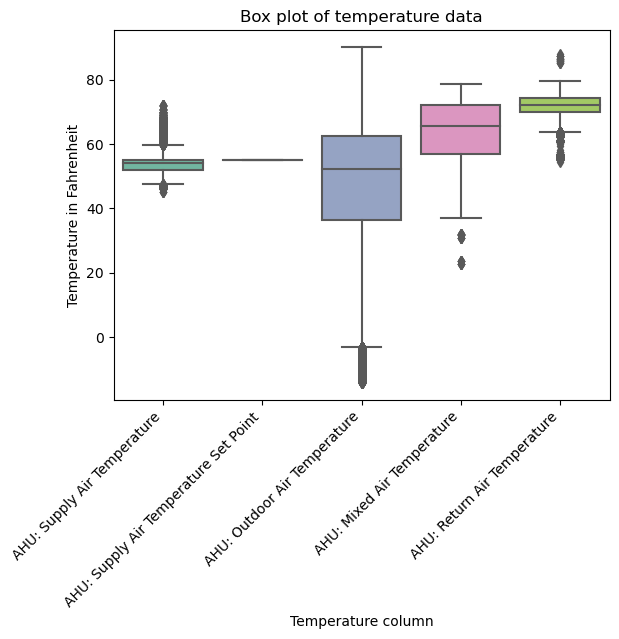

In [14]:
ax = sns.boxplot(x='Temperature column', y='Temperature in Fahrenheit', data=temp_data, palette="Set2")
plt.title("Box plot of temperature data")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

[Text(0, 0, 'AHU: Supply Air Fan Speed Control Signal'),
 Text(1, 0, 'AHU: Return Air Fan Speed Control Signal'),
 Text(2, 0, 'AHU: Outdoor Air Damper Control Signal  '),
 Text(3, 0, 'AHU: Return Air Damper Control Signal'),
 Text(4, 0, 'AHU: Cooling Coil Valve Control Signal'),
 Text(5, 0, 'AHU: Heating Coil Valve Control Signal')]

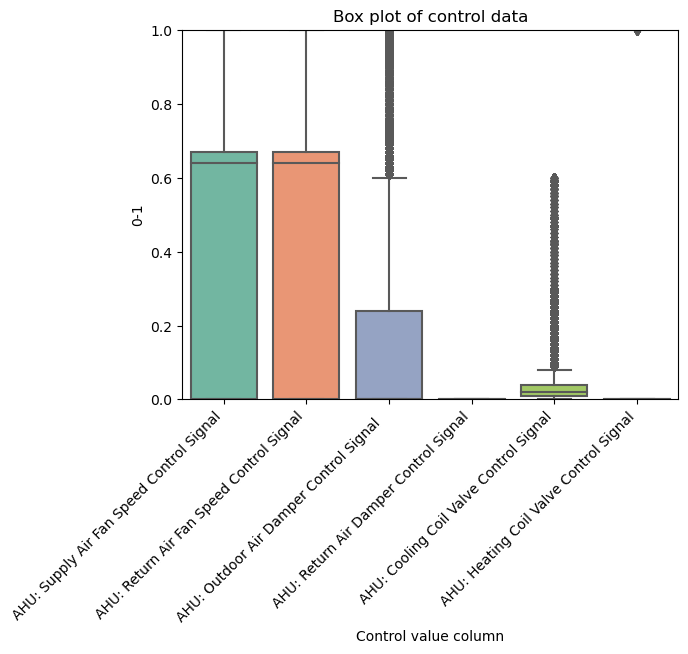

In [18]:
ax = sns.boxplot(x='Control value column', y='0-1', data=control_data, palette="Set2")
plt.title("Box plot of control data")
plt.ylim(0,1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

[Text(0, 0, 'AHU: Supply Air Duct Static Pressure Set Point'),
 Text(1, 0, 'AHU: Supply Air Duct Static Pressure')]

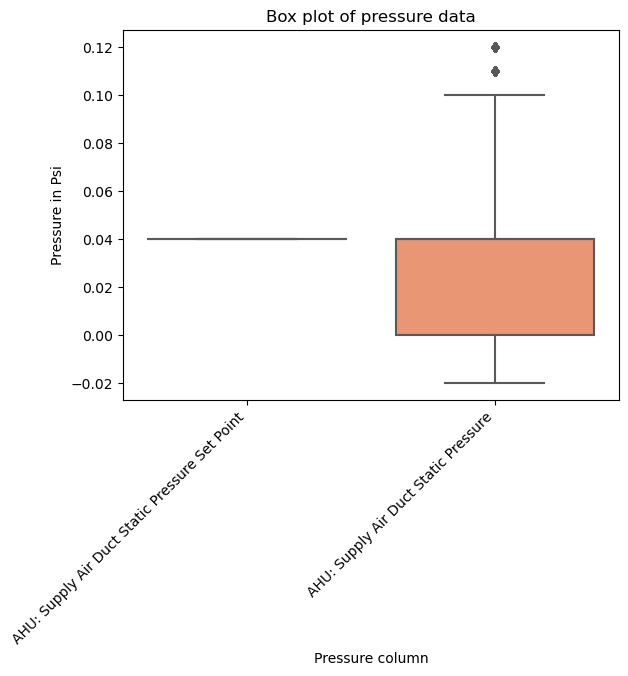

In [19]:
ax = sns.boxplot(x='Pressure column', y='Pressure in Psi', data=pressure_data, palette="Set2")
plt.title("Box plot of pressure data")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

In [20]:
data.describe()

,AHU: Supply Air Temperature,AHU: Supply Air Temperature Set Point,AHU: Outdoor Air Temperature,AHU: Mixed Air Temperature,AHU: Return Air Temperature,AHU: Supply Air Fan Status,AHU: Return Air Fan Status,AHU: Supply Air Fan Speed Control Signal,AHU: Return Air Fan Speed Control Signal,AHU: Outdoor Air Damper Control Signal,AHU: Return Air Damper Control Signal,AHU: Cooling Coil Valve Control Signal,AHU: Heating Coil Valve Control Signal,AHU: Supply Air Duct Static Pressure Set Point,AHU: Supply Air Duct Static Pressure,Occupancy Mode Indicator,Fault Detection Ground Truth
count,272160.000000,2.721600e+05,272160.000000,272160.000000,272160.000000,272160.000000,272160.000000,272160.000000,272160.000000,272160.000000,272160.000000,272160.000000,272160.000000,2.721600e+05,272160.000000,272160.000000,272160.000000
mean,53.762030,5.504000e+01,48.357590,65.000186,71.453754,0.670242,0.670242,0.480342,0.480342,0.213219,0.000009,0.043273,0.000077,4.000000e-02,0.034261,0.487654,0.857143
std,2.545891,3.741583e-10,20.154449,7.409942,3.702466,0.470126,0.470126,0.353275,0.353275,0.325107,0.004696,0.083905,0.008784,1.908546e-13,0.032849,0.499848,0.349928
min,44.950000,5.504000e+01,-14.260000,22.610000,54.470000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000e-02,-0.020000,0.000000,0.000000
25%,52.000000,5.504000e+01,36.320000,57.030000,70.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,4.000000e-02,0.000000,0.000000,1.000000
50%,54.070000,5.504000e+01,52.340000,65.570000,72.010000,1.000000,1.000000,0.640000,0.640000,0.000000,0.000000,0.020000,0.000000,4.000000e-02,0.040000,0.000000,1.000000
75%,55.040000,5.504000e+01,62.610000,72.020000,74.260000,1.000000,1.000000,0.670000,0.670000,0.240000,0.000000,0.040000,0.000000,4.000000e-02,0.040000,1.000000,1.000000
max,72.030000,5.504000e+01,90.140000,78.720000,87.870000,1.000000,1.000000,1.000000,1.000000,1.000000,2.450000,0.600000,1.000000,4.000000e-02,0.120000,1.000000,1.000000


Upon observation, it becomes apparent that the columns labeled "AHU: Supply Air Temperature Set Point" and "AHU: Supply Air Duct Static Pressure Set Point" have constant values. As a result, their potential utility in constructing the model appears to be limited.

Column "AHU: Return Air Damper Control Signal" has probably not correct values, because most of them are zeroes besides max anomalus value 2.45, when this values should be probably in range of 0-1.

Column "AHU: Heating Coil Valve Control Signal" seems to have nearly all zero values, which seems a bit odd because range of the outdoor temperatures are quite wide and we should expect a bit higher activity of this equipment. Regardless of whether the values in this column are correct or not, they will not be useful in building the model.

A noteworthy observation about the "Fault Detection Ground Truth" column, which is likely intended as a target column. Significantly, around 85% of this column contains fault-related data. This substantial imbalance in the dataset indicates the necessity for potential target engineering or data balancing techniques to ensure the efficacy of the model.

In [21]:
data = data.drop(['AHU: Supply Air Temperature Set Point', 'AHU: Supply Air Duct Static Pressure Set Point',
                 'AHU: Return Air Damper Control Signal', 'AHU: Heating Coil Valve Control Signal'], axis=1)

<AxesSubplot:>

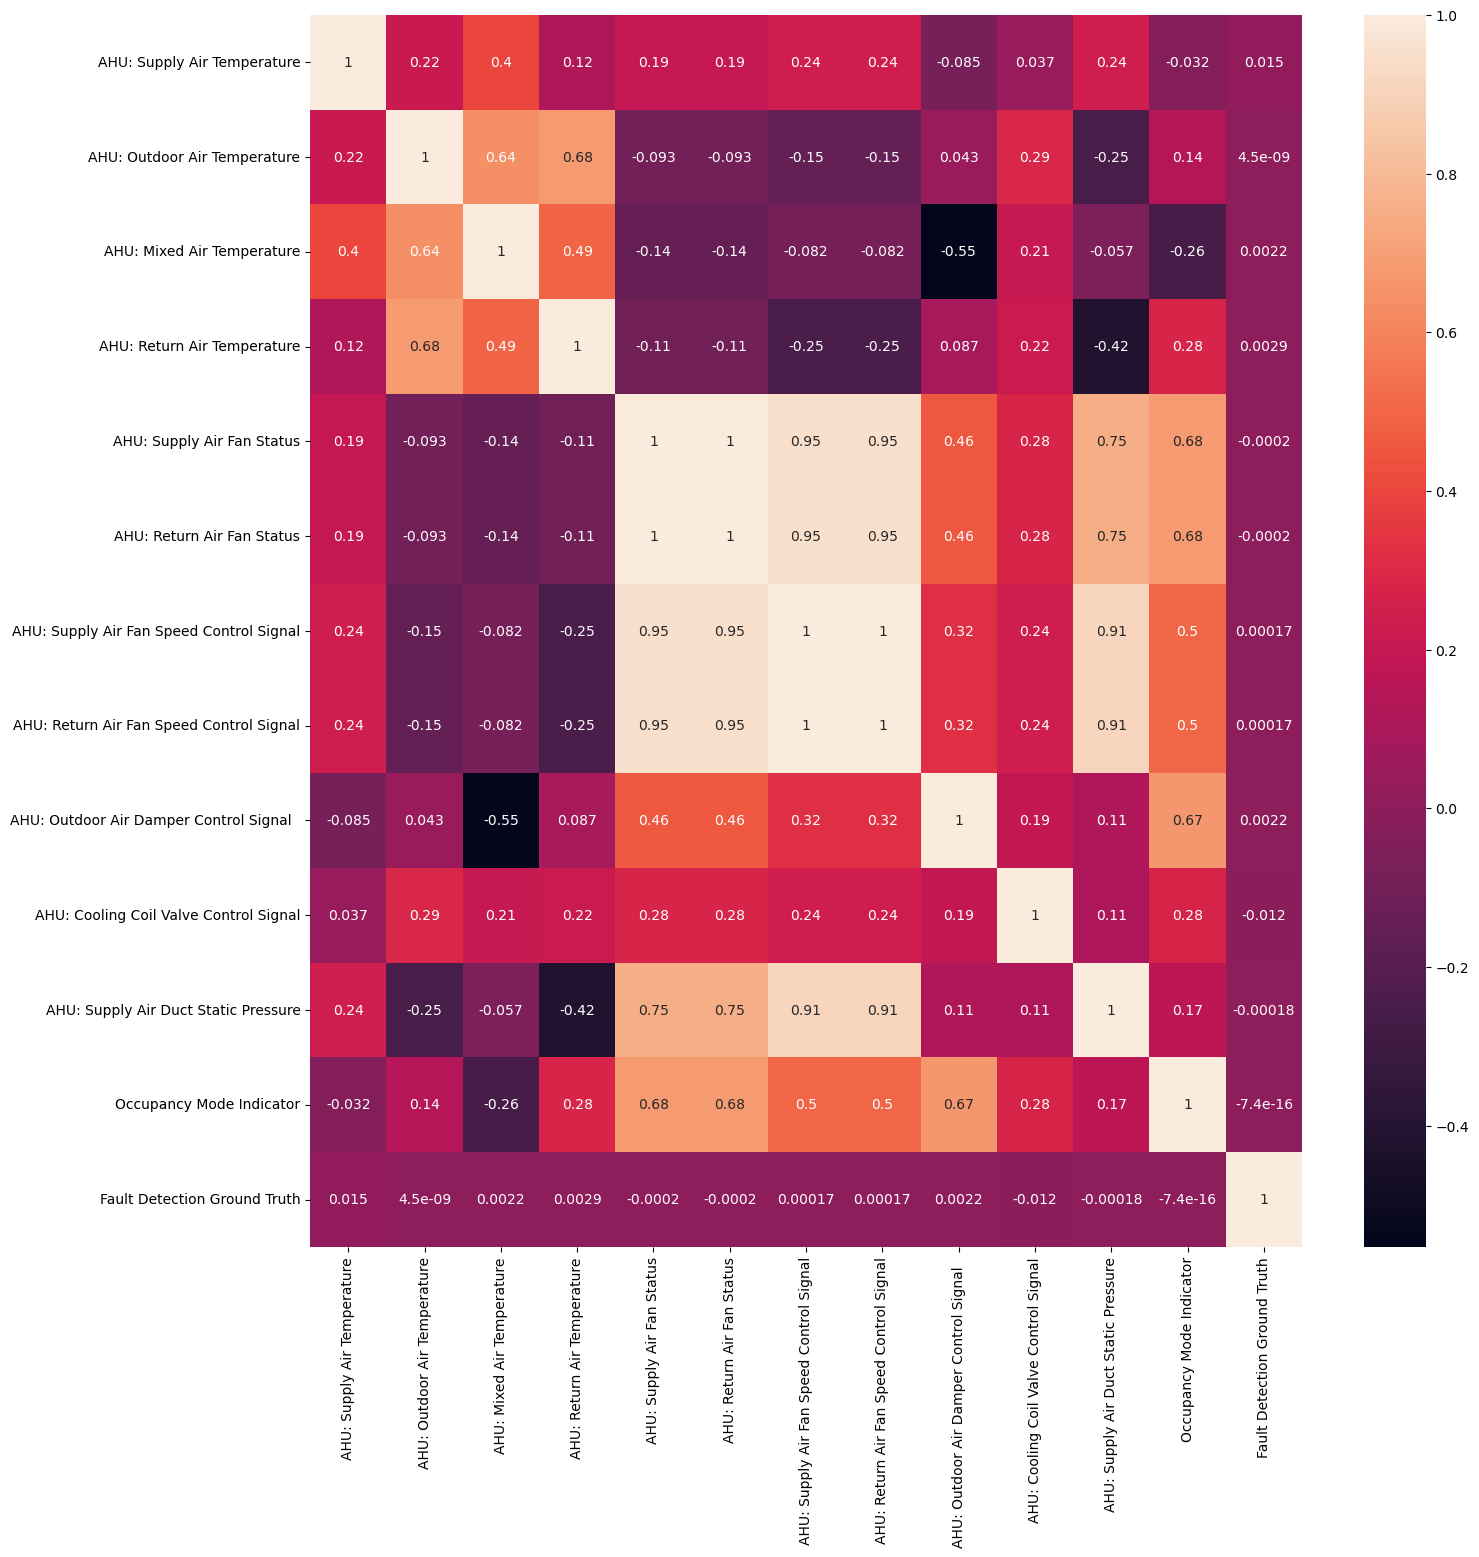

In [22]:
plt.figure(figsize=(16,16))
sns.heatmap(data.corr(), annot=True)

Four columns display significant correlation amongst themselves: "AHU: Supply Air Fan Status," "AHU: Return Air Fan Status," "AHU: Supply Air Fan Speed Control Signal," and "AHU: Return Air Fan Speed Control Signal." This correlation can likely be attributed to the control sequence, and as a result these columns essentially convey equivalent information. Therefore it is rational to retain only one of these columns.

In [23]:
data = data.drop(['AHU: Return Air Fan Status', 'AHU: Supply Air Fan Speed Control Signal', 'AHU: Return Air Fan Speed Control Signal'], axis=1)

<AxesSubplot:>

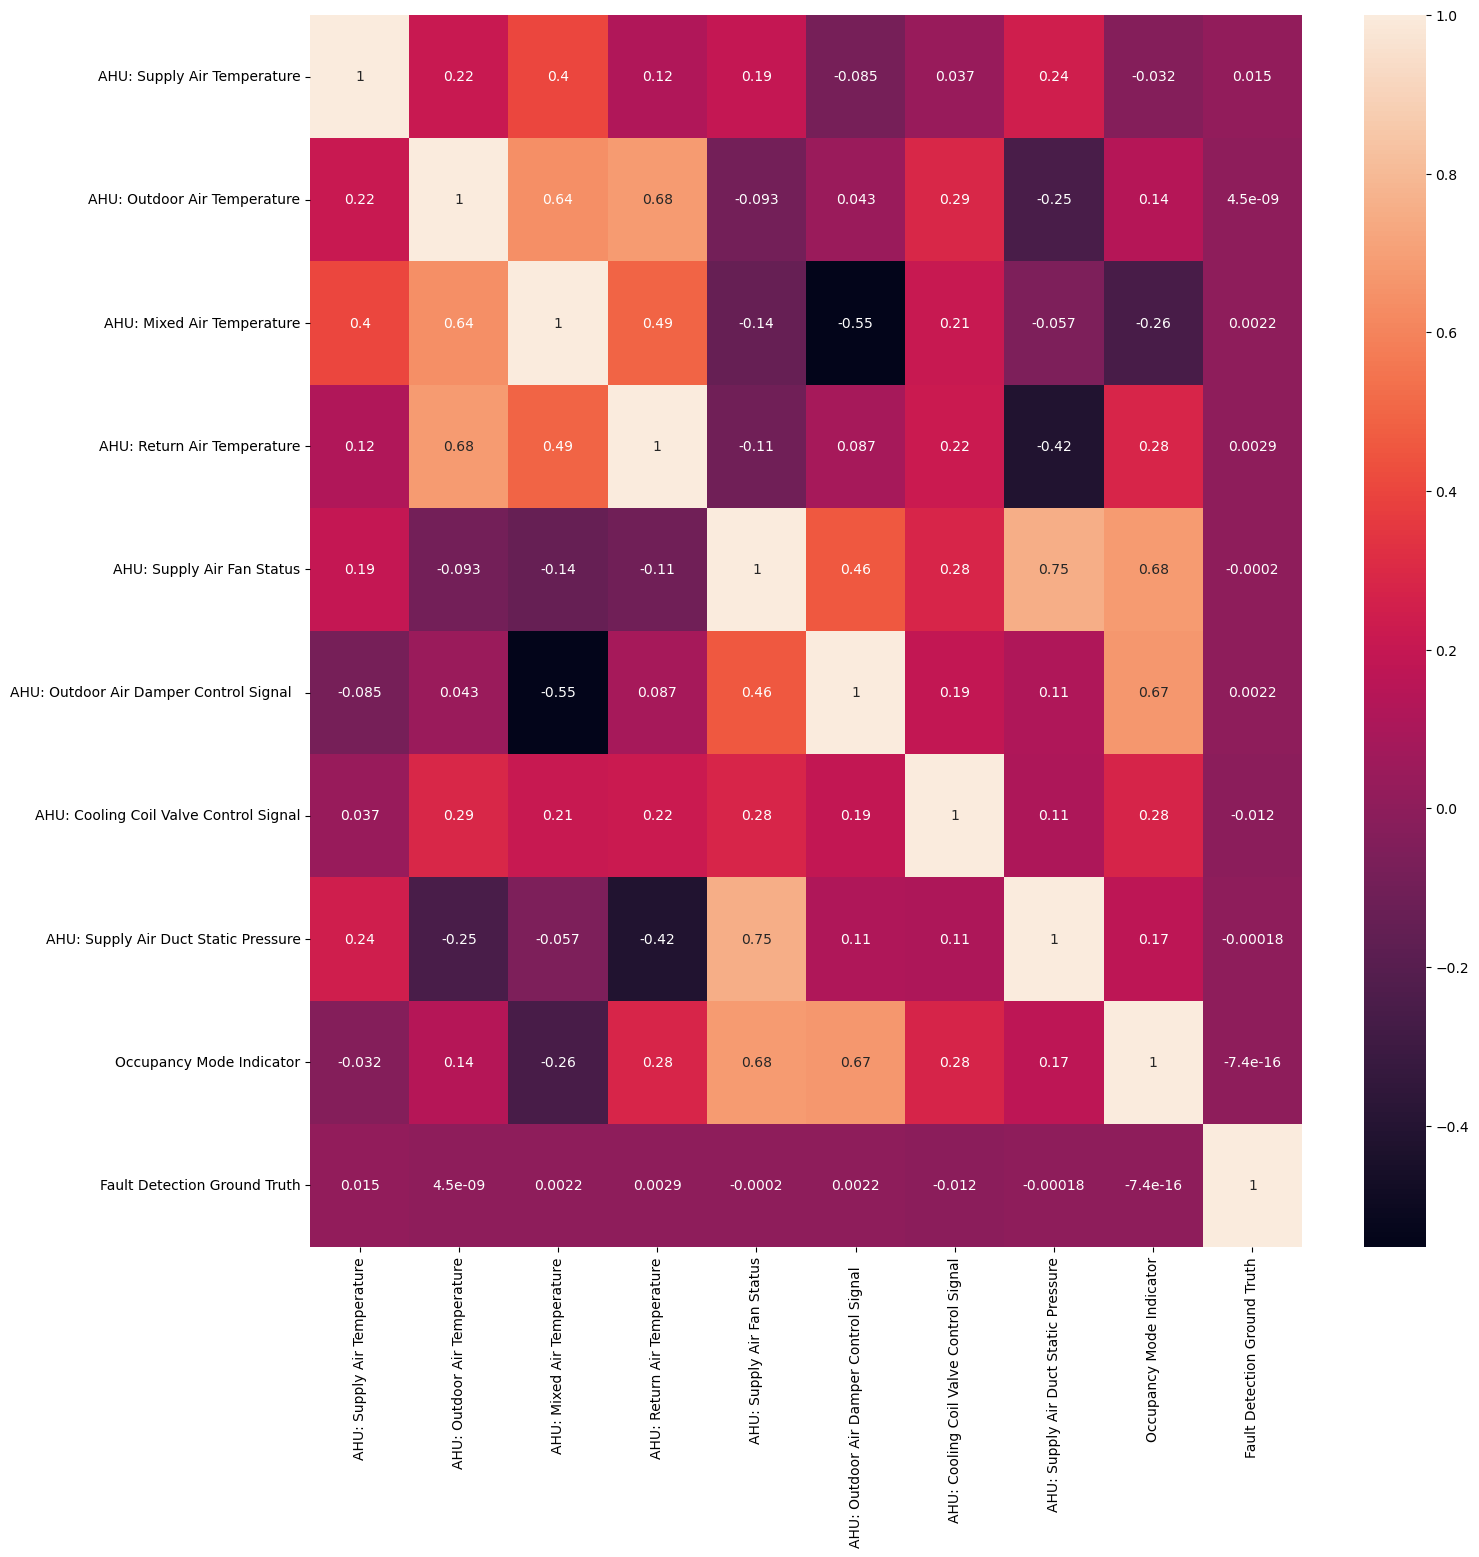

In [24]:
plt.figure(figsize=(16,16))
sns.heatmap(data.corr(), annot=True)

The correlation map above highlights a following observation: the "Fault Detection Ground Truth" column exhibits minimal correlation with any other variables. This column essentially contains binary values representing the presence or absence of a fault. This suggests that resolving this issue might not be possible by a straightforward application of classification algorithms.

An alternative approach is to frame this problem as a regression task. By altering the target from the "Fault Detection Ground Truth" column to the "AHU: Outdoor Air Temperature" column, we can calculate difference between actual and model-predicted values. This approach enables not only the identification of faults but also the quantification of the bias magnitude.

An essential wuestion is whether it's feasible to predict outdoor air temperature using data derived from the Air Handling Unit (AHU). In the end, the internal operations of the AHU do not directly impact the external weather conditions. The answer lies in the AHU's structure and control sequence. Particularly during Occupied Mode, the outside air and office-return air are blended within a mixed air chamber. This linkage is reflected in the strong correlations observed between return, mixed, and outdoor air temperatures, as illustrated in both the correlation map and the graph below.

It mean that in this approach it becomes imperative to constrain the dataset to periods when the AHU is in Occupied mode and the fan is operational.

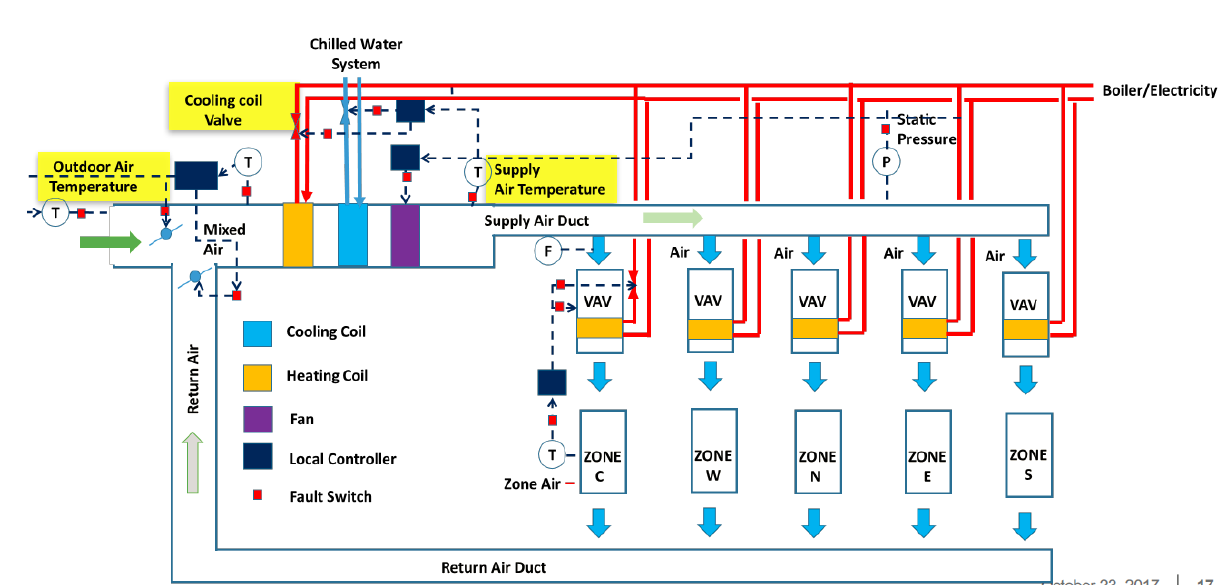

In [25]:
# Narrowing the dataset to periods when the AHU is in Occupied mode and the fan is operational.
data = data[(data['AHU: Supply Air Fan Status']==1) & (data['Occupancy Mode Indicator'] ==1)]

In [26]:
# We can drop columns 'AHU: Supply Air Fan Status','Occupancy Mode Indicator' now, because in dataset they have constant value now.
data.drop(['AHU: Supply Air Fan Status','Occupancy Mode Indicator'], axis=1, inplace=True)

In [27]:
data.describe()

,AHU: Supply Air Temperature,AHU: Outdoor Air Temperature,AHU: Mixed Air Temperature,AHU: Return Air Temperature,AHU: Outdoor Air Damper Control Signal,AHU: Cooling Coil Valve Control Signal,AHU: Supply Air Duct Static Pressure,Fault Detection Ground Truth
count,132720.000000,132720.000000,132720.000000,132720.000000,132720.000000,132720.000000,1.327200e+05,132720.000000
mean,53.679286,51.335159,63.037677,72.530509,0.437234,0.067174,4.000000e-02,0.857143
std,1.643037,21.076830,8.745370,1.849449,0.344664,0.096475,3.200924e-14,0.349928
min,47.350000,-14.260000,22.610000,55.090000,0.140000,0.010000,4.000000e-02,0.000000
25%,52.150000,38.360000,55.050000,71.100000,0.140000,0.010000,4.000000e-02,1.000000
50%,54.050000,56.490000,57.400000,72.400000,0.250000,0.030000,4.000000e-02,1.000000
75%,55.060000,66.230000,72.610000,74.300000,0.820000,0.070000,4.000000e-02,1.000000
max,58.700000,90.140000,76.740000,87.870000,1.000000,0.490000,4.000000e-02,1.000000


After deleting "AHU: Supply Air Fan Status" column "AHU: Supply Air Duct Static Pressure" have constant value so it also should be dropped from the dataset to prevent overfitting.

In [28]:
data.drop('AHU: Supply Air Duct Static Pressure', axis=1, inplace=True)

<AxesSubplot:>

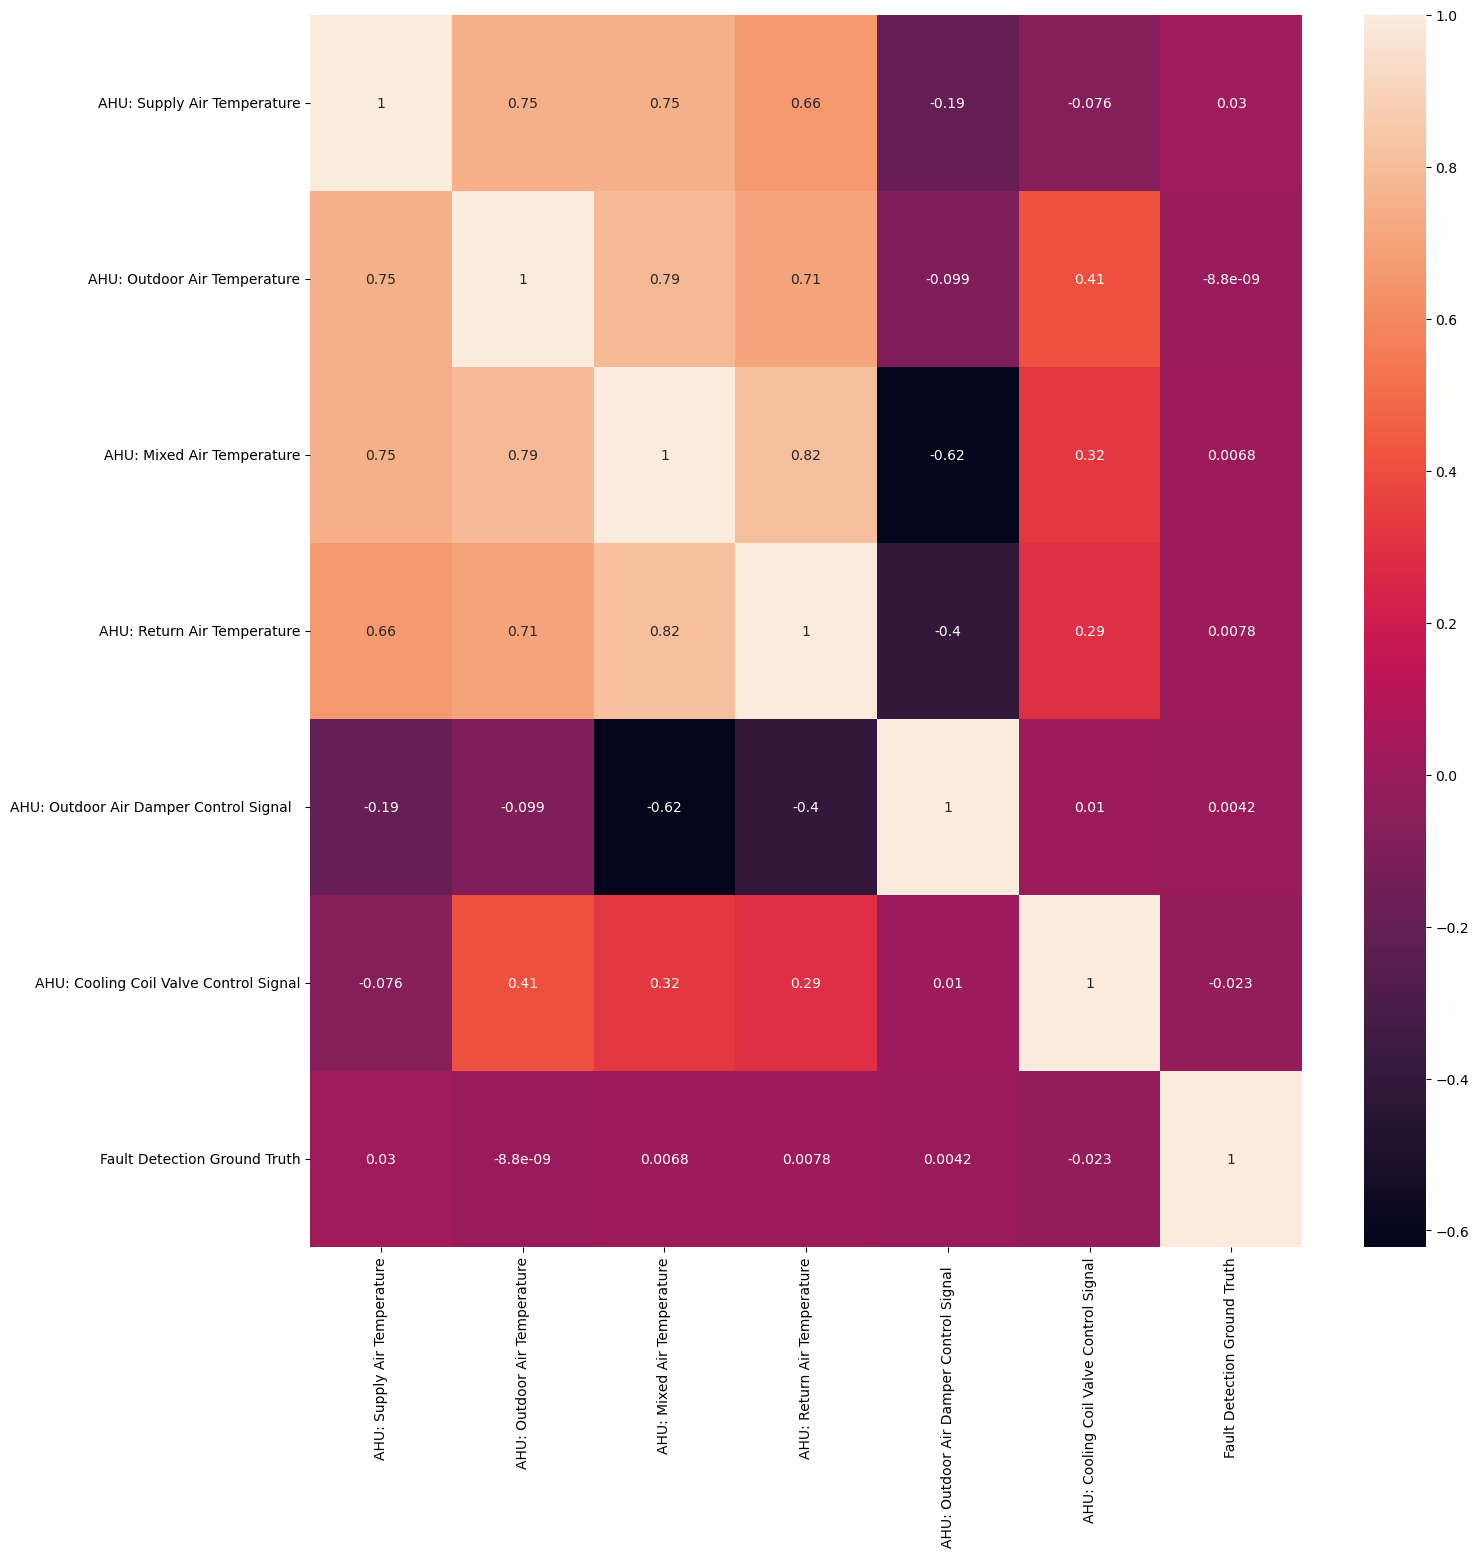

In [29]:
plt.figure(figsize=(16,16))
sns.heatmap(data.corr(), annot=True)

The dataset has now been refined to encompass all the necessary data required for accurate predictions of the outdoor air temperature sensor readings.

# Model building

## Feature and target data preparation

For the construction of this model, it is necessary to exclusively use unfaulted data. This approach ensures that the model learns from accurate information, mitigating the risk of incorporating erroneous patterns that could significantly undermine its effectiveness. Given the substantial size of the dataset, relying solely on unfaulted data should provide enough information for the model-building process.

In [30]:
X = data[data['Fault Detection Ground Truth'] == 0].drop(['Datetime','Fault Detection Ground Truth', 'AHU: Outdoor Air Temperature'], axis=1)

In [31]:
y = data[data['Fault Detection Ground Truth'] == 0]['AHU: Outdoor Air Temperature']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True)

### Regression models training

In [33]:
all_data = data.drop(['Datetime','Fault Detection Ground Truth', 'AHU: Outdoor Air Temperature'], axis=1)

In [34]:
models, acc = train_evaluate_regression_models(X_train, X_test, y_train, y_test, regressors)

Learning rate set to 0.064099
0:	learn: 19.3219964	total: 197ms	remaining: 3m 16s
1:	learn: 18.1708698	total: 204ms	remaining: 1m 41s
2:	learn: 17.0641331	total: 209ms	remaining: 1m 9s
3:	learn: 16.0115499	total: 215ms	remaining: 53.4s
4:	learn: 15.0452086	total: 220ms	remaining: 43.7s
5:	learn: 14.1335380	total: 225ms	remaining: 37.2s
6:	learn: 13.2907515	total: 230ms	remaining: 32.6s
7:	learn: 12.4910479	total: 235ms	remaining: 29.2s
8:	learn: 11.7439805	total: 239ms	remaining: 26.3s
9:	learn: 11.0387261	total: 243ms	remaining: 24s
10:	learn: 10.3891364	total: 247ms	remaining: 22.2s
11:	learn: 9.7675754	total: 251ms	remaining: 20.6s
12:	learn: 9.1943175	total: 254ms	remaining: 19.3s
13:	learn: 8.6651270	total: 258ms	remaining: 18.2s
14:	learn: 8.1607474	total: 262ms	remaining: 17.2s
15:	learn: 7.6873692	total: 266ms	remaining: 16.4s
16:	learn: 7.2441860	total: 270ms	remaining: 15.6s
17:	learn: 6.8445540	total: 274ms	remaining: 14.9s
18:	learn: 6.4584011	total: 278ms	remaining: 14.3s


179:	learn: 0.6377150	total: 952ms	remaining: 4.34s
180:	learn: 0.6338533	total: 961ms	remaining: 4.35s
181:	learn: 0.6317921	total: 971ms	remaining: 4.36s
182:	learn: 0.6303823	total: 978ms	remaining: 4.36s
183:	learn: 0.6280164	total: 984ms	remaining: 4.36s
184:	learn: 0.6257346	total: 989ms	remaining: 4.36s
185:	learn: 0.6243833	total: 993ms	remaining: 4.35s
186:	learn: 0.6229431	total: 997ms	remaining: 4.33s
187:	learn: 0.6210178	total: 1s	remaining: 4.34s
188:	learn: 0.6188227	total: 1.01s	remaining: 4.33s
189:	learn: 0.6162401	total: 1.01s	remaining: 4.32s
190:	learn: 0.6123433	total: 1.02s	remaining: 4.31s
191:	learn: 0.6104838	total: 1.02s	remaining: 4.3s
192:	learn: 0.6088328	total: 1.02s	remaining: 4.28s
193:	learn: 0.6076851	total: 1.03s	remaining: 4.27s
194:	learn: 0.6055293	total: 1.03s	remaining: 4.27s
195:	learn: 0.6029202	total: 1.04s	remaining: 4.26s
196:	learn: 0.6005624	total: 1.04s	remaining: 4.25s
197:	learn: 0.5973809	total: 1.05s	remaining: 4.24s
198:	learn: 0.59

367:	learn: 0.4021939	total: 1.71s	remaining: 2.94s
368:	learn: 0.4015644	total: 1.71s	remaining: 2.93s
369:	learn: 0.4008323	total: 1.72s	remaining: 2.93s
370:	learn: 0.4003613	total: 1.72s	remaining: 2.92s
371:	learn: 0.3997771	total: 1.73s	remaining: 2.92s
372:	learn: 0.3989794	total: 1.73s	remaining: 2.91s
373:	learn: 0.3981867	total: 1.74s	remaining: 2.9s
374:	learn: 0.3974479	total: 1.74s	remaining: 2.9s
375:	learn: 0.3969787	total: 1.74s	remaining: 2.89s
376:	learn: 0.3959960	total: 1.75s	remaining: 2.88s
377:	learn: 0.3956564	total: 1.75s	remaining: 2.88s
378:	learn: 0.3946626	total: 1.75s	remaining: 2.87s
379:	learn: 0.3943077	total: 1.76s	remaining: 2.87s
380:	learn: 0.3937397	total: 1.76s	remaining: 2.86s
381:	learn: 0.3930654	total: 1.76s	remaining: 2.86s
382:	learn: 0.3925494	total: 1.77s	remaining: 2.85s
383:	learn: 0.3915215	total: 1.77s	remaining: 2.85s
384:	learn: 0.3908823	total: 1.78s	remaining: 2.84s
385:	learn: 0.3901793	total: 1.78s	remaining: 2.84s
386:	learn: 0.

558:	learn: 0.3149711	total: 2.48s	remaining: 1.96s
559:	learn: 0.3146647	total: 2.49s	remaining: 1.96s
560:	learn: 0.3143432	total: 2.5s	remaining: 1.95s
561:	learn: 0.3138728	total: 2.5s	remaining: 1.95s
562:	learn: 0.3136720	total: 2.51s	remaining: 1.95s
563:	learn: 0.3134330	total: 2.51s	remaining: 1.94s
564:	learn: 0.3130246	total: 2.51s	remaining: 1.94s
565:	learn: 0.3127636	total: 2.52s	remaining: 1.93s
566:	learn: 0.3125623	total: 2.52s	remaining: 1.93s
567:	learn: 0.3123205	total: 2.53s	remaining: 1.92s
568:	learn: 0.3120616	total: 2.53s	remaining: 1.92s
569:	learn: 0.3118214	total: 2.54s	remaining: 1.91s
570:	learn: 0.3116278	total: 2.54s	remaining: 1.91s
571:	learn: 0.3114106	total: 2.54s	remaining: 1.9s
572:	learn: 0.3111825	total: 2.55s	remaining: 1.9s
573:	learn: 0.3109469	total: 2.55s	remaining: 1.9s
574:	learn: 0.3107695	total: 2.56s	remaining: 1.89s
575:	learn: 0.3103818	total: 2.56s	remaining: 1.89s
576:	learn: 0.3101551	total: 2.57s	remaining: 1.88s
577:	learn: 0.309

763:	learn: 0.2678796	total: 3.46s	remaining: 1.07s
764:	learn: 0.2676645	total: 3.47s	remaining: 1.06s
765:	learn: 0.2675319	total: 3.47s	remaining: 1.06s
766:	learn: 0.2672632	total: 3.48s	remaining: 1.06s
767:	learn: 0.2671060	total: 3.48s	remaining: 1.05s
768:	learn: 0.2670012	total: 3.49s	remaining: 1.05s
769:	learn: 0.2667471	total: 3.49s	remaining: 1.04s
770:	learn: 0.2665698	total: 3.5s	remaining: 1.04s
771:	learn: 0.2664654	total: 3.5s	remaining: 1.03s
772:	learn: 0.2662823	total: 3.5s	remaining: 1.03s
773:	learn: 0.2660907	total: 3.51s	remaining: 1.02s
774:	learn: 0.2658810	total: 3.51s	remaining: 1.02s
775:	learn: 0.2658131	total: 3.51s	remaining: 1.01s
776:	learn: 0.2656664	total: 3.52s	remaining: 1.01s
777:	learn: 0.2655573	total: 3.52s	remaining: 1s
778:	learn: 0.2654525	total: 3.52s	remaining: 1s
779:	learn: 0.2653614	total: 3.53s	remaining: 995ms
780:	learn: 0.2650802	total: 3.53s	remaining: 991ms
781:	learn: 0.2649609	total: 3.54s	remaining: 986ms
782:	learn: 0.2648456

937:	learn: 0.2382255	total: 4.22s	remaining: 279ms
938:	learn: 0.2381278	total: 4.22s	remaining: 274ms
939:	learn: 0.2380172	total: 4.23s	remaining: 270ms
940:	learn: 0.2379374	total: 4.23s	remaining: 265ms
941:	learn: 0.2378597	total: 4.24s	remaining: 261ms
942:	learn: 0.2377066	total: 4.24s	remaining: 256ms
943:	learn: 0.2375836	total: 4.24s	remaining: 252ms
944:	learn: 0.2375165	total: 4.25s	remaining: 247ms
945:	learn: 0.2372450	total: 4.25s	remaining: 243ms
946:	learn: 0.2371824	total: 4.26s	remaining: 238ms
947:	learn: 0.2370035	total: 4.26s	remaining: 234ms
948:	learn: 0.2369489	total: 4.26s	remaining: 229ms
949:	learn: 0.2368955	total: 4.27s	remaining: 225ms
950:	learn: 0.2367762	total: 4.27s	remaining: 220ms
951:	learn: 0.2366216	total: 4.28s	remaining: 216ms
952:	learn: 0.2365632	total: 4.28s	remaining: 211ms
953:	learn: 0.2364986	total: 4.28s	remaining: 207ms
954:	learn: 0.2362729	total: 4.29s	remaining: 202ms
955:	learn: 0.2361985	total: 4.29s	remaining: 197ms
956:	learn: 

### Models evaluation

In [35]:
print(acc)

                       model  train_R2   test_R2  train_Mae  test_Mae  \
0        KNeighborsRegressor  0.998914  0.998232   0.083564  0.134360   
1               MLPRegressor  0.995322  0.995200   0.811538  0.857878   
2          AdaBoostRegressor  0.981307  0.980186   2.302886  2.390140   
3  GradientBoostingRegressor  0.998817  0.998597   0.510271  0.546754   
4          CatBoostRegressor  0.999874  0.999101   0.152905  0.187680   
5               XGBRegressor  0.999952  0.999803   0.091397  0.123452   
6           BaggingRegressor  0.999938  0.999682   0.026511  0.064997   
7      RandomForestRegressor  0.999948  0.999707   0.023634  0.060614   
8      DecisionTreeRegressor  0.999999  0.999410   0.004201  0.070755   
9           LinearRegression  0.930892  0.931255   4.044740  4.036536   

   train_Mse   test_Mse  
0   0.460358   0.762494  
1   1.983409   2.070529  
2   7.925865   8.547025  
3   0.501452   0.605048  
4   0.053218   0.387771  
5   0.020440   0.084921  
6   0.026084  

The outcomes above have demonstrated that the majority of used regression models exhibited excellent performance in forecasting outside air temperature using unfaulted data. To comprehensively evaluae the efficacy of these models, however, it is necessary to evaluate their performance across the entire dataset. This entails scrutinizing whether the difference between predicted and actual data aligns with the bias introduced by the dataset authors. To do this analysis, it is necessary to establish an additional column that encompasses the factual bias values.

The table below shows us biases used in the dataset.

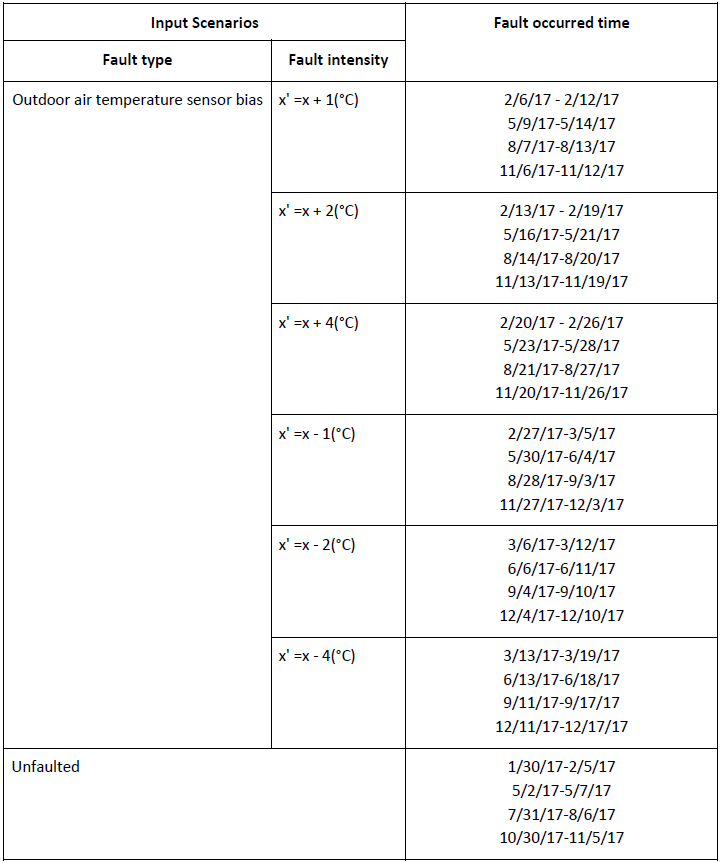

In [36]:
# Creating list of dates when faults occured accordin to the description.
date_ranges_1 = [
        (convert_date('2/6/17'), convert_date('2/12/17')),
        (convert_date('5/9/17'), convert_date('5/14/17')),
        (convert_date('8/7/17'), convert_date('8/13/17')),
        (convert_date('11/6/17'), convert_date('11/12/17'))
    ]
date_ranges_2 = [
        (convert_date('2/13/17'), convert_date('2/19/17')),
        (convert_date('5/16/17'), convert_date('5/21/17')),
        (convert_date('8/14/17'), convert_date('8/20/17')),
        (convert_date('11/13/17'), convert_date('11/19/17'))
    ]
date_ranges_3 = [
        (convert_date('2/20/17'), convert_date('2/26/17')),
        (convert_date('5/23/17'), convert_date('5/28/17')),
        (convert_date('8/21/17'), convert_date('8/27/17')),
        (convert_date('11/20/17'), convert_date('11/26/17'))
    ]
date_ranges_4 = [
        (convert_date('2/27/17'), convert_date('3/5/17')),
        (convert_date('5/30/17'), convert_date('6/4/17')),
        (convert_date('8/28/17'), convert_date('9/3/17')),
        (convert_date('11/27/17'), convert_date('12/3/17'))
    ]
date_ranges_5 = [
        (convert_date('3/6/17'), convert_date('3/12/17')),
        (convert_date('6/6/17'), convert_date('6/11/17')),
        (convert_date('9/4/17'), convert_date('9/10/17')),
        (convert_date('12/4/17'), convert_date('12/10/17'))
    ]
date_ranges_6 = [
        (convert_date('3/13/17'), convert_date('3/19/17')),
        (convert_date('6/13/17'), convert_date('6/18/17')),
        (convert_date('9/11/17'), convert_date('9/17/17')),
        (convert_date('12/11/17'), convert_date('12/17/17'))
    ]


In [37]:
# Creating copy of the dataset to store model results in it.
data_1 = data.copy()

In [38]:
for model in models:
    name = str(model).split()[0]
    data_1[f'{name} prediction'] = model.predict(all_data)
    data_1[f'{name} anomaly'] = data_1['AHU: Outdoor Air Temperature'] - data_1[f'{name} prediction']

In [39]:
# Creating and filling "Bias" column with appropiate values, changing bias unit to Fahreheit to match with other columns.
data['Bias'] = 0
for start_date, end_date in date_ranges_1:
    data.loc[(data['Datetime'] >= start_date) & (data['Datetime'] <= end_date), 'Bias'] = 1.8
for start_date, end_date in date_ranges_2:
    data.loc[(data['Datetime'] >= start_date) & (data['Datetime'] <= end_date), 'Bias'] = 3.6
for start_date, end_date in date_ranges_3:
    data.loc[(data['Datetime'] >= start_date) & (data['Datetime'] <= end_date), 'Bias'] = 7.2
for start_date, end_date in date_ranges_4:
    data.loc[(data['Datetime'] >= start_date) & (data['Datetime'] <= end_date), 'Bias'] = - 1.8
for start_date, end_date in date_ranges_5:
    data.loc[(data['Datetime'] >= start_date) & (data['Datetime'] <= end_date), 'Bias'] = - 3.6
for start_date, end_date in date_ranges_6:
    data.loc[(data['Datetime'] >= start_date) & (data['Datetime'] <= end_date), 'Bias'] = - 7.2

In [40]:
# Preparing DataFrame to store model evauation parameters.
results_accuracy_final = pd.DataFrame(index=None, columns=['model','R2','Mae','Mse'])

In [41]:
# Creating list of column containing diffence between predicted and actual values.
anomal_col = [col for col in data_1.columns if "anomaly" in col]

In [42]:
# Creating the loop to fill DataFrame with models evalusation parameters.
for column in anomal_col:
    R2 = r2_score(data['Bias'], data_1[column])
    mse = mean_squared_error(data['Bias'], data_1[column])
    mae = mean_absolute_error(data['Bias'], data_1[column])
    name = column.split()[0]
    results_accuracy_final = results_accuracy_final.append(pd.Series({'model':name, 
                                'R2':R2,
                                'Mae': mae,
                                'Mse':mse}),ignore_index=True )

In [43]:
print(results_accuracy_final)

                              model        R2       Mae        Mse
0             KNeighborsRegressor()  0.850211  0.475662   2.911897
1                    MLPRegressor()  0.884801  0.891580   2.239468
2               AdaBoostRegressor()  0.460218  2.638649  10.493363
3       GradientBoostingRegressor()  0.905788  0.788445   1.831478
4  <catboost.core.CatBoostRegressor  0.930991  0.463979   1.341528
5      XGBRegressor(base_score=0.5,  0.956750  0.338764   0.840776
6                BaggingRegressor()  0.944621  0.320492   1.076574
7           RandomForestRegressor()  0.948242  0.308887   1.006182
8           DecisionTreeRegressor()  0.941745  0.313678   1.132475
9                LinearRegression() -1.034608  4.620440  39.552776


The results above reveals that the scores on a whole dataset are somewhat diminished in comparison to the dataset featuring unfaulted sensor bias. This can likely be attributed to the relative scarcity of unfaulted data within the dataset. Nonetheless, models continue to exhibit substantial capability, remaining well-suited for the task at hand. Particularly, models boasting an R2 score surpassing 0.9 could be considered viable options, given their mean absolute error falls below the minimal bias imposed by the authors.

# Final conclusions

The introduced model has proven effective in addressing the challenge of Outside Air temperature sensor bias. It's important to acknowledge, however, that the applicability of this model is constrained to the specific system configuration. Attempting to employ such a model in alternative scenarios, such as where Air Handling Units (AHUs) provide a full 100 percent fresh air supply, would likely not yield good results.